### **SVM Multiclassifier for body performance**

The Multiclassifier for body performance leverages extensive historical data from 13,000 individuals, aiming to categorize people into four distinct health levels (A, B, C, D). Utilizing a diverse set of physical performance metrics such as strength, stretching capacity, age, height, and other relevant factors, this model provides valuable insights into individuals' physical well-being.

### **Healthy level description**

Health Levels and Recommended Actions:

### *A: Apex Vitality (The Pinnacle Performers)*

Individuals in this category exhibit exceptional physical health and prowess.
*Recommended Actions:*
Maintain regular exercise routines to sustain peak performance.
Focus on balanced nutrition and hydration.
Encourage participation in advanced fitness activities to challenge and enhance abilities.

### *B: Robust Wellness (The Steady Strivers)*

Individuals in this category demonstrate robust health and overall well-being.
*Recommended Actions:*
Engage in regular physical activities to maintain and improve current fitness levels.
Emphasize flexibility and agility exercises to enhance overall mobility.
Monitor and manage stress levels for holistic health.

### *C: Moderate Health (The Health Conscious)*

Individuals in this category possess a moderate level of physical health.
*Recommended Actions:*
Adopt a well-rounded exercise routine that includes both cardiovascular and strength-training exercises.
Focus on improving specific areas of weakness identified by the model.
Explore healthier dietary choices and portion control.

### *D: Developing Health (The Path to Progress)*

Individuals in this category are in the early stages of their health journey, with room for improvement.
*Recommended Actions:*
Consult with fitness professionals or healthcare providers to create a personalized fitness plan.
Start with low-impact exercises and gradually increase intensity.
Embrace a balanced diet, emphasizing fruits, vegetables, and whole grains.

This model, designed to assess and guide individuals toward their optimal physical performance, offers personalized recommendations tailored to each health level. By embracing the suggested actions and adopting a proactive approach to well-being, individuals can progress through the health categories, ultimately achieving their peak physical vitality.

In [52]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import joblib

from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

## **0. Load the data**

In [2]:
data = pd.read_csv('bodyPerformance.csv')

## **1. Exploratory Data Analysis**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [4]:
data.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [5]:
data.value_counts("class")

class
C    3349
D    3349
A    3348
B    3347
dtype: int64

The data provided seems to be very clean. There is no missing values and data is balanced. We have to take into consideration that it is a multiclass problem. Let's plot some graphs to understand the data behind the classification problem:

**1.1 Pairplot analysis**

In [3]:
pairplot = sns.pairplot(data, hue="class")

NameError: name 'data' is not defined

**1.1 Correlation analysis**

In [6]:
data["class"] = data["class"].replace({"A": 1, "B": 2, "C":3, "D":4})

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  int64  
dtypes: float64(10), int64(1), object(1)
memory usage: 1.2+ MB


In [8]:
X_num = data.select_dtypes([float])
X_cat = data.select_dtypes([object])

In [9]:
X_num

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
0,27.0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0
1,25.0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0
2,31.0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0
3,32.0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0
4,28.0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0
...,...,...,...,...,...,...,...,...,...,...
13388,25.0,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0
13389,21.0,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0
13390,39.0,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0
13391,64.0,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0


In [10]:
correlation_numerical = X_num.corrwith(data['class'])
print(correlation_numerical)

age                        0.065612
height_cm                  0.037753
weight_kg                  0.214129
body fat_%                 0.341956
diastolic                  0.066761
systolic                   0.035484
gripForce                 -0.136088
sit and bend forward_cm   -0.588123
sit-ups counts            -0.452832
broad jump_cm             -0.262154
dtype: float64


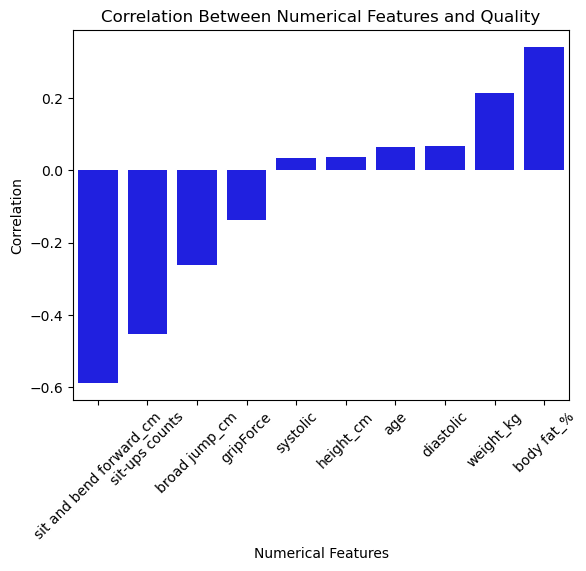

In [11]:
sorted_correlations = correlation_numerical.sort_values()
sns.barplot(x=sorted_correlations.index, y=sorted_correlations.values, color="Blue")
plt.title('Correlation Between Numerical Features and Quality')
plt.xlabel('Numerical Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.show()

**1.2 Correlation matrix among features**

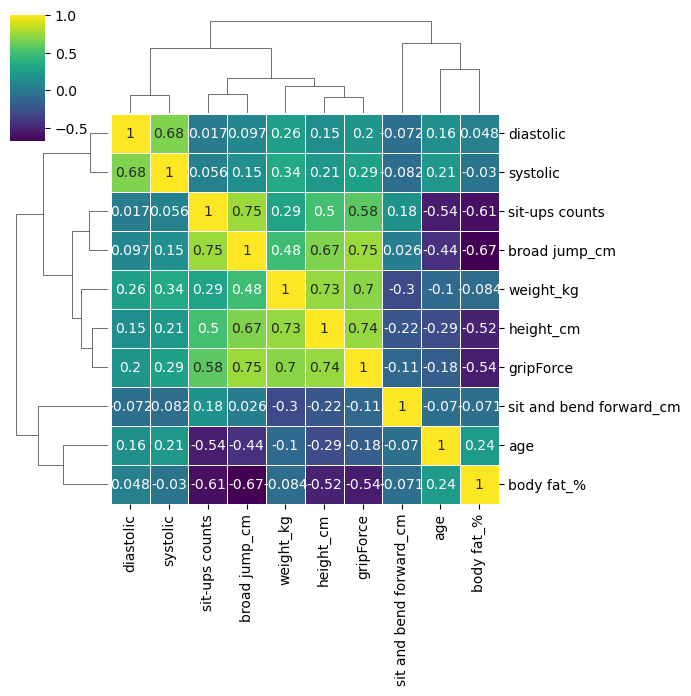

In [12]:
import seaborn as sns

# Calculate the correlation matrix for numerical features
correlation_matrix = X_num.corr()

# Create a cluster map
cluster_grid = sns.clustermap(correlation_matrix, cmap='viridis', annot=True, linewidths=.5, figsize=(7, 7))

# Print the cluster map object
print(cluster_grid)

In [13]:
X = data.drop(columns="class")
y = data["class"]

**1.3 Univariate analysis**

In [14]:
def plot_univariate_hist(feature_name):
    return px.histogram(data, x=feature_name, nbins=100, color="class", marginal="box", template="none", title=f"Histogram: {feature_name}", histnorm="probability density")

In [71]:
plot_univariate_hist("body fat_%")

**1.4 Managing outliers**

In [15]:
def remove_outliers_iqr(df):
    # Copy the input DataFrame to avoid modifying the original DataFrame
    df_cleaned = data.copy()
    
    # Iterate over numeric columns
    numeric_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
    rows_with_outliers = 0
    
    for column in numeric_cols:
        # Calculate IQR for the column
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define lower and upper bounds
        lower_bound = Q1 - 3.0 * IQR
        upper_bound = Q3 + 3.0 * IQR
        
        # Identify and remove rows with outliers
        outliers = (df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)
        rows_with_outliers += outliers.sum()
        df_cleaned = df_cleaned[~outliers]
    
    return rows_with_outliers, df_cleaned


In [17]:
outlier_count, df_no_outliers = remove_outliers_iqr(data)

# Output the number of rows with outliers and the DataFrame without outliers
print("Number of rows with outliers:", outlier_count)
print("DataFrame without outliers:")
print(df_no_outliers)

Number of rows with outliers: 31
DataFrame without outliers:
        age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
0      27.0      M      172.3      75.24        21.3       80.0     130.0   
1      25.0      M      165.0      55.80        15.7       77.0     126.0   
2      31.0      M      179.6      78.00        20.1       92.0     152.0   
3      32.0      M      174.5      71.10        18.4       76.0     147.0   
4      28.0      M      173.8      67.70        17.1       70.0     127.0   
...     ...    ...        ...        ...         ...        ...       ...   
13388  25.0      M      172.1      71.80        16.2       74.0     141.0   
13389  21.0      M      179.7      63.90        12.1       74.0     128.0   
13390  39.0      M      177.2      80.50        20.1       78.0     132.0   
13391  64.0      F      146.1      57.70        40.4       68.0     121.0   
13392  34.0      M      164.0      66.10        19.5       82.0     150.0   

       gripFor

In [18]:
df_no_outliers = pd.DataFrame(df_no_outliers, columns=data.columns)
df_no_outliers

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,3
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,1
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,3
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,2
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
13388,25.0,M,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0,3
13389,21.0,M,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0,4
13390,39.0,M,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0,1
13391,64.0,F,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0,4


## **2.0 Building the model**

In [34]:
X = df_no_outliers.drop(columns=["class"])
y = df_no_outliers["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99, stratify=y)

**2.1 Preprocessing**

In [47]:
categorical_columns = X.select_dtypes(["O","int"]).columns
numerical_columns = X.select_dtypes(["float"]).columns

In [48]:
preprocessing = ColumnTransformer(       ## You can call fit, fit_transform, transform with this object
    [
        (
            "ohe",
            OneHotEncoder(sparse_output=False),
            categorical_columns
        ),
        (
            "scaler",
            StandardScaler(),
            numerical_columns
        )
    ],
    remainder="drop"  # this can be "drop", "passthrough", or another Estimator
)

In [45]:
X_train_full = preprocessing.fit_transform(X_train)

In [53]:
joblib.dump(preprocessing, 'preprocessing_column_transformer.sav')

['preprocessing_column_transformer.sav']

In [25]:
X_test_full = preprocessing.transform(X_test)

In [42]:
# transform to DataFrame
X_new = pd.DataFrame(X_train_full, columns=preprocessing.get_feature_names_out())

In [43]:
X_new

,ohe__gender_F,ohe__gender_M,scaler__age,scaler__height_cm,scaler__weight_kg,scaler__body fat_%,scaler__diastolic,scaler__systolic,scaler__gripForce,scaler__sit and bend forward_cm,scaler__sit-ups counts,scaler__broad jump_cm
0,0.0,1.0,0.451840,0.050536,0.092430,-1.498616,0.104568,-0.715751,0.813330,0.619885,1.060930,1.218873
1,1.0,0.0,1.990269,-1.666876,-0.478526,1.948759,-1.120397,-0.441277,-1.048169,-1.373304,-2.076036,-2.122152
2,1.0,0.0,0.964650,-0.612740,-0.360976,0.804231,-1.214625,-1.950884,-1.216546,1.115087,-0.612119,-1.299362
3,1.0,0.0,-1.159846,-1.572122,-1.108257,0.169914,-1.214625,0.107671,-1.244608,0.570364,0.433537,0.321285
4,0.0,1.0,0.744874,0.524305,0.445079,-0.809141,0.104568,-0.715751,0.710433,-0.036258,0.154695,-0.302041
...,...,...,...,...,...,...,...,...,...,...,...,...
9348,0.0,1.0,0.158806,0.678280,0.428286,-0.740193,-0.272345,0.313526,1.786174,-0.593361,0.363827,0.296352
9349,1.0,0.0,0.012289,-1.939293,-1.536473,0.228879,0.669936,-1.264699,-1.749739,-1.670426,-0.612119,-1.424027
9350,1.0,0.0,1.037908,-1.133886,0.176394,1.659180,0.858392,-0.029566,-0.870438,0.038022,-2.076036,-1.573625
9351,0.0,1.0,1.770493,-0.127127,-1.057878,-1.084931,0.481480,0.244908,0.149177,0.718925,-1.239512,0.620481


In [44]:
X_new.to_csv("input_data.csv", index=False)

## **2. Model**

In [28]:
svc_classifier = SVC(random_state=99, probability=True, kernel="linear")

In [29]:
model = Pipeline(steps=[("preprocessing", preprocessing), ("classifier", svc_classifier)])

In [30]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  Index(['gender'], dtype='object')),
                                                 ('scaler', StandardScaler(),
                                                  Index(['age', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic', 'systolic',
       'gripForce', 'sit and bend forward_cm', 'sit-ups counts',
       'broad jump_cm'],
      dtype='object'))])),
                ('classifier',
                 SVC(kernel='linear', probability=True, random_state=99))])

In [31]:
X_test_full = preprocessing.transform(X_test)

In [32]:
X_test_full = pd.DataFrame(X_test_full, columns=preprocessing.get_feature_names_out())

In [33]:
X_test_full

,ohe__gender_F,ohe__gender_M,scaler__age,scaler__height_cm,scaler__weight_kg,scaler__body fat_%,scaler__diastolic,scaler__systolic,scaler__gripForce,scaler__sit and bend forward_cm,scaler__sit-ups counts,scaler__broad jump_cm
0,0.0,1.0,-0.500520,-0.304790,-0.159463,-0.229982,1.894900,1.548659,0.588828,0.124682,0.642668,1.393405
1,1.0,0.0,0.671616,-1.287861,-1.897519,-0.671246,-2.062677,-2.156739,-0.982689,0.830346,-0.681829,-0.626170
2,0.0,1.0,1.330942,-1.086509,-0.846289,-1.029773,0.669936,0.382145,0.186594,-0.803822,0.503247,-1.324295
3,0.0,1.0,-0.354003,0.725657,0.789331,-0.547140,-0.931941,-0.784369,1.589734,0.038022,0.921509,0.869811
4,0.0,1.0,1.550718,0.844099,1.175566,0.156124,1.800672,1.754514,0.448514,0.446564,-0.263567,0.495816
...,...,...,...,...,...,...,...,...,...,...,...,...
4004,1.0,0.0,1.184425,-2.116956,-1.670816,0.749073,0.010340,-0.166803,-1.319443,-0.531461,-2.076036,-1.773089
4005,0.0,1.0,0.158806,0.251888,0.571025,0.294019,-0.272345,-1.470554,0.747850,0.062782,0.015275,0.371151
4006,1.0,0.0,1.111167,-1.098353,-1.099860,0.100966,-0.460801,-0.304040,-0.926563,0.941766,-1.239512,-0.850567
4007,0.0,1.0,-0.500520,1.365245,0.470268,-1.425639,0.010340,-0.372659,1.973259,0.483704,0.991220,0.869811


## **3.0 Hyper parameter tuning**

In [61]:
# Define the parameter distribution for Randomized Search
param_dist = {
    'C': [0.1, 1, 10, 100, 1000],  # C choices
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel choices
    'gamma': ['scale', 'auto', 0.1, 0.5, 1.0]  # Gamma choices
}

In [62]:
# Create an SVC classifier
svc_classifier = SVC(random_state=42)

In [63]:
# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(svc_classifier, param_distributions=param_dist, n_iter=10, cv=5,n_jobs=-1, random_state=42, refit=True)

In [65]:
random_search.fit(X_train_full, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': ['scale', 'auto', 0.1, 0.5,
                                                  1.0],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   random_state=42)

In [66]:
# Get the best estimator after Randomized Search
best_svc = random_search.best_estimator_

## **4.0 Evaluation**

In [67]:
# Make predictions on the test set
predictions = best_svc.predict(X_test_full)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
confusion_mat = confusion_matrix(y_test, predictions)

In [68]:
# Print the results
print("Best Hyperparameters after Randomized Search:", random_search.best_params_)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion_mat)

Best Hyperparameters after Randomized Search: {'kernel': 'poly', 'gamma': 'auto', 'C': 10}
Accuracy: 0.6889498628086804
Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.78      0.75      1004
           2       0.53      0.61      0.57      1003
           3       0.65      0.63      0.64      1004
           4       0.92      0.74      0.82       998

    accuracy                           0.69      4009
   macro avg       0.71      0.69      0.69      4009
weighted avg       0.70      0.69      0.69      4009

Confusion Matrix:
 [[782 208  14   0]
 [211 613 158  21]
 [ 76 254 630  44]
 [ 13  76 172 737]]


## **5.0 Saving the Model**

In [69]:
from sklearn.preprocessing import LabelEncoder
import pickle

In [73]:
filename = 'trained_health_SVClassification_model.sav'
pickle.dump(best_svc,open(filename,'wb'))